In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import gc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from imblearn.over_sampling import SMOTENC, SMOTE
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# Read the data

In [2]:
df = pd.read_csv('datasets/text_emotion.csv')
df.drop(['tweet_id', 'author'], inplace=True, axis=1)

In [3]:
def common_user(s):
    return re.sub(r'@\w+', 'user', s)

In [4]:
df.content = df.content.apply(common_user)

# Preprocessing && Oversampling

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
df.head()

,sentiment,content
0,empty,user i know i was listenin to bad habit earli...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,user We want to trade with someone who has Hou...


In [7]:
le = LabelEncoder()
df.iloc[:, 0] = le.fit_transform(df.iloc[:, 0])

In [8]:
df.head()

,sentiment,content
0,2,user i know i was listenin to bad habit earli...
1,10,Layin n bed with a headache ughhhh...waitin o...
2,10,Funeral ceremony...gloomy friday...
3,3,wants to hang out with friends SOON!
4,8,user We want to trade with someone who has Hou...


In [9]:
le.classes_

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

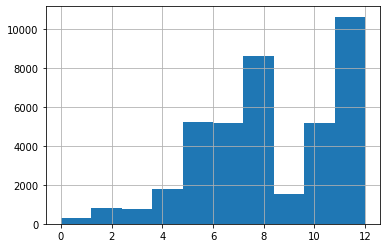

In [10]:
df.sentiment.hist()

In [11]:
df.shape

(40000, 2)

In [13]:
X = df.content
y = df.sentiment

In [14]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use
EMBEDDING_FILE = 'datasets/glove.twitter.27B.100d.txt'

In [15]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
list_tokenized_train = tokenizer.texts_to_sequences(X)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [30]:
def sentence_to_sequences(s):
    return pad_sequences(tokenizer.texts_to_sequences(s), maxlen=maxlen)

In [124]:
def predict(model, s):
    return le.inverse_transform(np.argmax(model.predict(sentence_to_sequences(s)), axis=1))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.20, random_state=42)

In [17]:
sm = SMOTE(random_state=42, n_jobs=-1)
X_over, y_over = sm.fit_resample(X_train, y_train)

In [18]:
from collections import Counter
Counter(y_over)

Counter({8: 6898,
         4: 6898,
         12: 6898,
         6: 6898,
         11: 6898,
         10: 6898,
         7: 6898,
         5: 6898,
         9: 6898,
         2: 6898,
         3: 6898,
         1: 6898,
         0: 6898})

In [19]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
y_train_onehot = onehotencoder.fit_transform(y_over.reshape(-1, 1)).toarray()
y_test_onehot = onehotencoder.transform(y_test.values.reshape(-1, 1)).toarray()

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Model

In [20]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf-8'))

In [21]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_mean, emb_std

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(0.02631098, 0.58370703)

In [22]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [23]:
gc.collect()

204

In [26]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(13, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 13)                663       
Total para

In [28]:
model.fit(X_over, y_train_onehot, batch_size=64, epochs=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 80706 samples, validate on 8968 samples
Epoch 1/1
80706/80706 [==============================] - 433s 5ms/step - loss: 0.2564 - acc: 0.9231 - val_loss: 0.4249 - val_acc: 0.9231


In [29]:
model.evaluate(X_test, y_test_onehot)

8000/8000 [==============================] - 27s 3ms/step


[0.2324436382651329, 0.9231153883934021]

# Save the model

In [151]:
import pickle

In [154]:
pickle.dump(model, open('model.pkl', 'wb'))